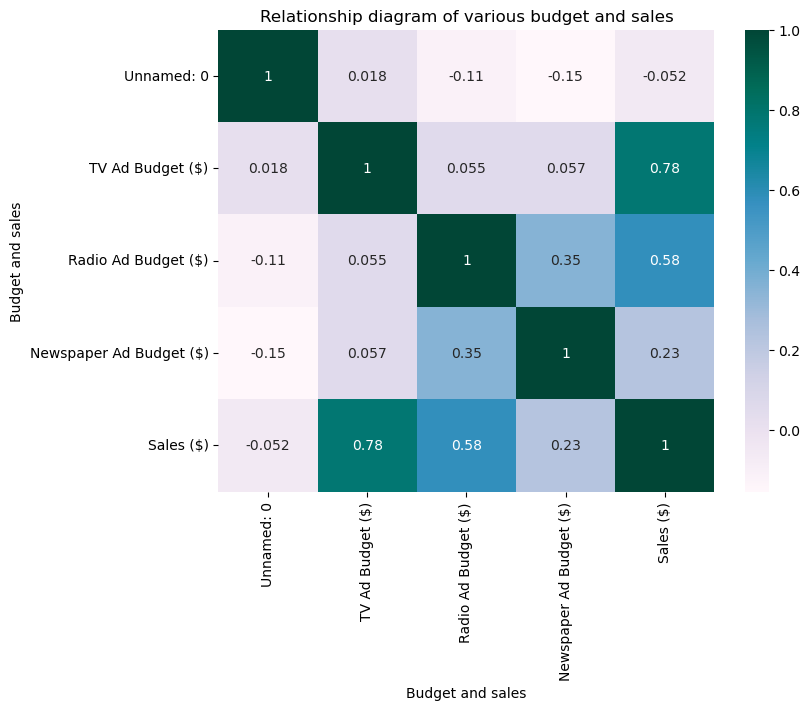

Mean Squared Error: 1.8065160373411995


NotImplementedError: 

In [6]:
import pandas as pd # 讀取數據集
import numpy as np 
import seaborn as sns # NumPy與Pandas的圖形化介面
import matplotlib.pyplot as plt

# Scikit-learn 建立機器學習模型
from sklearn.model_selection import train_test_split, GridSearchCV # 數據集劃分；交叉驗證使參數優化
from sklearn.linear_model import Ridge 
from sklearn.metrics import mean_squared_error # 均方誤差MSE(計算預測值與真實值的均方誤差)

from scipy.optimize import minimize # 最小化目標函數&最優解

import flet as ft # 引入Flet庫

########## 熱力圖 ##########
# 讀取數據集
dataset = pd.read_csv('Ad_dataset.csv')

# 提取特徵和目標變量
x = dataset[['TV Ad Budget ($)', 'Radio Ad Budget ($)', 'Newspaper Ad Budget ($)']]
y = dataset['Sales ($)']

# 查看特徵與目標變量之間的相關性(熱力圖)
plt.figure(figsize=(8, 6))
correlation_matrix = dataset.corr() #計算各個數值(特徵與目標變量)相關係數
sns.heatmap(correlation_matrix, annot=True, cmap='PuBuGn') #繪製熱力圖
plt.title('Relationship diagram of various budget and sales')
plt.xlabel('Budget and sales')
plt.ylabel('Budget and sales')
plt.show()

########## 機器學習建立數學模型 ##########
# 超參數調整範圍(alpha是Ridge回歸模型正則化參數)，使用不同的alpha訓練及評估模型
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}

# 使用 Grid Search 進行超參數調整
ridge = Ridge() 
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error') # 調整模型；優化參數；分成子集數；負均方根
grid_search.fit(x, y) # 在x、y上執行網格搜索，並交叉驗證
optimal_model = grid_search.best_estimator_ # 輸出最優模型

# 建立模型，進模型開始訓練
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=72)
optimal_model.fit(x_train, y_train)
y_predict = optimal_model.predict(x_test)# 計算均方根
MSE = mean_squared_error(y_test, y_predict) 
print(f'Mean Squared Error: {MSE}')

########## 最佳化過程 ##########
# 定義最小化目標函數
def optimize_budget_allocation(budget_list):
    budget_dataframe = pd.DataFrame([budget_list], columns=['TV Ad Budget ($)', 'Radio Ad Budget ($)', 'Newspaper Ad Budget ($)'])
    return -optimal_model.predict(budget_dataframe)[0] # 使用負值實現最大化目標

# 初始預算分配值
initial_budget_allocation = [50000, 10000, 5000]

# 邊界條件
bounds = [(0, None), (0, None), (0, None)]

# 用 Nelder-Mead 找到最小值 
result = minimize(optimize_budget_allocation, initial_budget_allocation, bounds=bounds, method='Nelder-Mead')
optimal_budget_allocation = result.x

# 分配函數
def allocate_budget(total_budget):
    scaled_budget = total_budget / sum(optimal_budget_allocation)
    return [int(scaled_budget * budget) for budget in optimal_budget_allocation]

# 預測銷售額函數
def predict_sales(budget_allocation):
    budget_dataframe = pd.DataFrame([budget_allocation], columns=['TV Ad Budget ($)', 'Radio Ad Budget ($)', 'Newspaper Ad Budget ($)'])
    return optimal_model.predict(budget_dataframe)[0]

########## GUI 介面 ##########
import nest_asyncio
import asyncio

async def main(page: ft.Page):
    global start_station, end_station
    page.window_width = 800
    page.window_height = 700
    page.horizontal_alignment = ft.CrossAxisAlignment.CENTER

    data_original = []

    page.title = "Optimization of Budget Allocation for Advertising"
    page.theme = ft.theme.Theme(color_scheme_seed="purple")
    
    # 進入視窗
    def welcome_message():
        welcome_dialog = ft.AlertDialog(
            title=ft.Text("Welcome to this program"),
            content=ft.Text("Please start here to estimate your optimal advertising budget allocation."),
            actions=[
                ft.TextButton("Continue", on_click=close_welcome_message)
            ],
            on_dismiss=lambda e: print("Dialog dismissed!")
        )
        page.dialog = welcome_dialog
        welcome_dialog.open = True
        page.update()

    def close_welcome_message(e):
        page.dialog.open = False
        page.update()
        start_main()  
    
    # 起始畫面設定
    def start_main():
        total_budget_field = ft.TextField(
            label="Total Budget :", #標籤
            border="underline", #框邊
            width=400, 
            text_size=15,
            prefix_text="NT$", #開頭語
            hint_text=" Please enter budget here") #隱藏訊息
        tv_budget_field = ft.TextField(
            label="TV Budget :",
            border="underline",
            width=400,
            text_size=15,
            prefix_text="NT$",
            hint_text=" Please enter budget here")
        radio_budget_field = ft.TextField(
            label="Radio Budget :",
            border="underline", width=400,
            text_size=15, prefix_text="NT$",
            hint_text=" Please enter budget here")
        newspaper_budget_field = ft.TextField(
            label="Newspaper Budget :",
            border="underline",
            width=400,
            text_size=15,
            prefix_text="NT$",
            hint_text=" Please enter budget here")

        result_list = ft.ListView(expand=True, spacing=18)
        result_list2 = ft.ListView(expand=True, spacing=18)

        # 錯誤訊息
        def error_message(message):
            error_dialog = ft.AlertDialog(
                title=ft.Text("Error"),
                content=ft.Text(message),
                actions=[ft.TextButton("Close", on_click=error_reset)],on_dismiss=lambda e: print("Dialog dismissed!")
            )
            page.dialog = error_dialog
            error_dialog.open = True
            page.update()
        
        # 彈跳式視窗重置鍵
        def error_reset(e):
            reset_fields(e)
            page.dialog.open = False
            page.update()
    
        # 計算預算與結果
        def calculate_allocation(e):
            try:
                # 定義各項預算
                total_budget = float(total_budget_field.value)
                tv_budget = float(tv_budget_field.value)
                radio_budget = float(radio_budget_field.value)
                newspaper_budget = float(newspaper_budget_field.value)
                
                #匯率換算
                exchange_rates = {
                    'NT$':1,
                    'US$': 0.03,
                    'EUR€': 0.029,  
                    'JPY¥': 4.93   
                }                

                selected_currencies = [currency for currency, checkbox in currency_checkboxes.items() if checkbox.value]
                
                def convert_currency(value, rate) : 
                    return value * rate

                # 預算值
                budget_alloc = [tv_budget, radio_budget, newspaper_budget]

                # 預測銷售額
                predicted_sales = predict_sales(budget_alloc)

                # 最優化後的預算
                optimized_budget_alloc = allocate_budget(total_budget)
                
                # 預測最佳化的銷售額
                predicted_sales_optimized = predict_sales(optimized_budget_alloc)      

                result_list.controls.clear()
                result_list2.controls.clear()
              
                for currency in selected_currencies:
                    rate = exchange_rates[currency]
                
                    total_budget_converted = convert_currency(total_budget, rate)
                    budget_alloc_converted = [convert_currency(budget, rate) for budget in budget_alloc]
                    predicted_sales_converted = convert_currency(predicted_sales, rate)
                
                    optimized_budget_alloc_converted = [convert_currency(budget, rate) for budget in optimized_budget_alloc]
                    predicted_sales_optimized_converted = convert_currency(predicted_sales_optimized, rate)
                    
                    # 銷售量比較
                    sales_growth_rate = predicted_sales_optimized_converted / predicted_sales_converted
                    
                    result_text = (
                        f"Initial Allocation:\n"
                        f"Total Budget: {currency}{total_budget_converted:.2f}\n"
                        f"TV Budget: {currency}{budget_alloc_converted[0]:.2f}\n"
                        f"Radio Budget: {currency}{budget_alloc_converted[1]:.2f}\n"
                        f"Newspaper Budget: {currency}{budget_alloc_converted[2]:.2f}\n"
                        f"Predicted Sales: {currency}{predicted_sales_converted:.2f}\n"
                    )
                    result_list.controls.append(ft.Text(result_text))
                    
                    result_text2 = (
                         f"Optimized Allocation ({currency}):\n"
                         f"Total Budget: {currency}{total_budget_converted:.2f}\n"
                         f"TV Budget: {currency}{optimized_budget_alloc_converted[0]:.2f}\n"
                         f"Radio Budget: {currency}{optimized_budget_alloc_converted[1]:.2f}\n"
                         f"Newspaper Budget: {currency}{optimized_budget_alloc_converted[2]:.2f}\n"
                         f"Predicted Sales: {currency}{predicted_sales_optimized_converted:.2f}\n"
                         f"Sales Growth Rate: {sales_growth_rate:.2f}"
                    )
                    result_list2.controls.append(ft.Text(result_text2))
            
                page.update()
            except ValueError:
                error_message("Please input correct format (number) !!")

        # 匯率選擇格
        currency_checkboxes = {
            'NT$': ft.Checkbox(label="NT"),
            'US$': ft.Checkbox(label="US"),
            'EUR€': ft.Checkbox(label="EUR"),
            'JPY¥': ft.Checkbox(label="JPY"),
        }
    
        #設置重置鍵
        def reset_fields(e):
            total_budget_field.value = ""
            tv_budget_field.value = ""
            radio_budget_field.value = ""
            newspaper_budget_field.value = ""
            result_list.controls.clear()
            result_list2.controls.clear()
            page.update()
     
        # 設置按鈕
        estimate_button = ft.ElevatedButton(text="Estimate", on_click=calculate_allocation)
        reset_button = ft.ElevatedButton(text="Reset", on_click=reset_fields)

        # 滾動式視窗顯示結果
        result_container = ft.Container(
            content=ft.Column(
                controls=[
                    ft.Text("Initial Results (NT$)", style=ft.TextStyle(weight=ft.FontWeight.BOLD)),
                    result_list,
                ],
                expand=True,
                spacing=15
            ),
            height=180,
            width=300,
            border=ft.border.all(0),
            padding=10
        )
    
        result_container2 = ft.Container(
            content=ft.Column(
                controls=[
                    ft.Text("Optimized Results", style=ft.TextStyle(weight=ft.FontWeight.BOLD)),
                    result_list2,
                ],
                expand=True,
                spacing=15
            ),
            height=180,
            width=300,
            border=ft.border.all(0),
            padding=10
        )
    
        # 視窗並排(同row)
        result_row = ft.Row(
            controls=[result_container, result_container2],
            alignment=ft.MainAxisAlignment.CENTER  # 使滾動式視窗位於介面中間
        )
    
        currency_checkboxes_row = ft.Row(
            controls=[currency_checkboxes['NT$'],currency_checkboxes['US$'],currency_checkboxes['EUR€'],currency_checkboxes['JPY¥']],
            alignment=ft.MainAxisAlignment.CENTER  # 使滾動式視窗位於介面中間
        )        

        # 建立GUI介面
        page.add(
            total_budget_field,
            tv_budget_field,
            radio_budget_field,
            newspaper_budget_field,
            currency_checkboxes_row,
            estimate_button,        
            result_row,
            reset_button
        )

    welcome_message()

nest_asyncio.apply()
ft.app(target=main)
